## Fit ALS Model

This notebook preps, fits and tunes an ALS model.  The objective is to obtain customer and user factors to be used as features in predictive models

In [1]:
import shutil
import pandas as pd
import numpy as np
import pickle
import boto3
from sagemaker import get_execution_role
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import scipy.sparse as sparse
import csv
import ast

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#!pip install implicit
import implicit

#!pip install hyperopt
from hyperopt import hp, Trials, fmin, tpe

from data_prep.prep_data_for_ALS import *
from train.model import *

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
role = get_execution_role()
region = boto3.Session().region_name
bucket = "udacity-machine-learning-capstone-data"

### Import the customer transaction file

In [3]:
key = "udacity_capstone_data/all_trans.pkl"
s3 = boto3.client("s3")
trans_pkl = s3.download_file(bucket, key, "./data/all_trans.pkl")

In [4]:
s3 = boto3.resource("s3")
all_cust_trans = pickle.loads(s3.Bucket(bucket).Object(key).get()["Body"].read())
all_cust_trans.head()

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,PROD_CODE_40,CUST_CODE,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
0,200607,20060415,7,19,1,0.93,PRD0900033,CL00201,DEP00067,G00021,D00005,CUST0000410727,UM,OT,994100100398294,L,MM,Full Shop,Mixed,STORE00001,LS,E02
1,200607,20060413,5,20,1,1.03,PRD0900097,CL00001,DEP00001,G00001,D00001,CUST0000634693,LA,YF,994100100532898,L,LA,Top Up,Fresh,STORE00001,LS,E02
2,200607,20060416,1,14,1,0.98,PRD0900121,CL00063,DEP00019,G00007,D00002,NaN,NaN,NaN,994100100135562,L,MM,Top Up,Grocery,STORE00001,LS,E02
3,200607,20060415,7,19,1,3.07,PRD0900135,CL00201,DEP00067,G00021,D00005,CUST0000410727,UM,OT,994100100398294,L,MM,Full Shop,Mixed,STORE00001,LS,E02
4,200607,20060415,7,19,1,4.81,PRD0900220,CL00051,DEP00013,G00005,D00002,CUST0000410727,UM,OT,994100100398294,L,MM,Full Shop,Mixed,STORE00001,LS,E02


### Summarize to customer and count of products purchased

Create a DataFrame at the customer and product level with count of the quantity of units purchased as implicit feedback

In [5]:
prep_als = als_data_prep(all_cust_trans, 200716, 200815)

In [6]:
cust_quant_summ = prep_als.create_cust_quant_summ()
cust_quant_summ.head()

,CUST_CODE,PROD_CODE,QUANTITY
0,CUST0000000013,PRD0900121,1
1,CUST0000000013,PRD0900139,1
2,CUST0000000013,PRD0900161,1
3,CUST0000000013,PRD0900234,3
4,CUST0000000013,PRD0900330,1


### Winsorize the DataFrame to remove outliers

In [7]:
winsorized_list = prep_als.winsorize_df(
    train_df=cust_quant_summ,
    test_df=None,
    valid_df=None,
    cols=["QUANTITY"],
    lower=0.05,
    upper=0.05,
    test_set=False,
    valid_set=False,
)

In [8]:
cust_summ_train = winsorized_list[0]

In [9]:
cust_summ_train.sort_values(["CUST_CODE", "PROD_CODE"]).head()

,CUST_CODE,PROD_CODE,QUANTITY
0,CUST0000000013,PRD0900121,1
1,CUST0000000013,PRD0900139,1
2,CUST0000000013,PRD0900161,1
3,CUST0000000013,PRD0900234,3
4,CUST0000000013,PRD0900330,1


### Normalize the data with a min/max scaler

In [10]:
normalized_list = prep_als.normalize_min_max(
    train_df=cust_summ_train,
    test_df=None,
    valid_df=None,
    group_var="PROD_CODE",
    normal_var="QUANTITY",
    test_set=False,
    valid_set=False,
)

In [11]:
train_df_normal = normalized_list[0]

In [12]:
train_df_normal.sort_values(["CUST_CODE", "PROD_CODE"]).head()

,CUST_CODE,PROD_CODE,QUANTITY
0,CUST0000000013,PRD0900121,0.010000
1856,CUST0000000013,PRD0900139,0.010000
2058,CUST0000000013,PRD0900161,0.010000
2143,CUST0000000013,PRD0900234,0.029231
2657,CUST0000000013,PRD0900330,0.010000


### Remove random rows from each customer to use as a test set

As ALS needs all customers to build the model, random customer/product rows will be held out to use as a test set

In [13]:
test_df, train_df = prep_als.create_als_train_test(train_df_normal, frac=0.1)
test_df.head()

,CUST_CODE,PROD_CODE,QUANTITY
0,CUST0000003447,PRD0900121,0.026279
1,CUST0000010712,PRD0900121,0.010000
2,CUST0000010921,PRD0900121,0.010000
3,CUST0000016376,PRD0900121,0.014651
4,CUST0000016975,PRD0900121,0.010000


### Create the index mapping on CUST_CODE and PROD_CODE

The ALS aglorithm requires that the customer vector and product vector be integers - these functions create and merge the mapping

In [14]:
# Create the customer and items mapping files
train_cust_mapping = prep_als.create_mapping(train_df, "CUST_CODE")

In [15]:
train_items_mapping = prep_als.create_mapping(train_df, "PROD_CODE")

In [16]:
train_df_mapped = prep_als.merge_mapping(
    train_df, train_cust_mapping, train_items_mapping
)
train_df_mapped.sort_values(["CUST_CODE"]).head()

,CUST_CODE,PROD_CODE,QUANTITY,index_CUST_CODE,index_PROD_CODE
0,CUST0000000013,PRD0900121,0.010,0,120
6925,CUST0000000013,PRD0903497,0.010,0,3496
4899,CUST0000000013,PRD0902522,0.035,0,2521
3202,CUST0000000013,PRD0901297,0.010,0,1296
5613,CUST0000000013,PRD0902846,0.010,0,2845


In [17]:
test_df_mapped = prep_als.merge_mapping(
    test_df, train_cust_mapping, train_items_mapping
)
test_df_mapped.sort_values(["CUST_CODE"]).head()

,CUST_CODE,PROD_CODE,QUANTITY,index_CUST_CODE,index_PROD_CODE
29036,CUST0000000013,PRD0904158,0.038846,0,4157
11559,CUST0000000013,PRD0900139,0.010000,0,138
29347,CUST0000000013,PRD0902860,0.010000,0,2859
20620,CUST0000000013,PRD0904311,0.010000,0,4310
29755,CUST0000000055,PRD0901006,1.010000,1,1005


### Create the sparse matrix required by ALS

In [18]:
purchases_sparse = prep_als.create_sparse_matrix(train_df_mapped)

In [19]:
purchases_sparse

<4997x4364 sparse matrix of type '<class 'numpy.float64'>'
	with 427908 stored elements in Compressed Sparse Row format>

In [20]:
# Check the sparsity of the matrix
matrix_size = purchases_sparse.shape[0] * purchases_sparse.shape[1]
num_purchases = len(purchases_sparse.nonzero()[0])
sparsity = 100 * (1 - (num_purchases / matrix_size))
sparsity

98.03774106810557

### Hyperparameter tuning

Tune the alpha, number of factors, regularization parameter and number of iterations

In [21]:
# Create the object to fit and tune ALS
als_model = fit_and_tune_als(purchases_sparse)

In [22]:
# Define the search space
space = {
    "alpha": hp.choice("alpha", np.arange(5, 50 + 1, 5, dtype=int)),
    "num_factors": hp.choice("num_factors", np.arange(5, 30 + 1, 5, dtype=int)),
    "reg": hp.choice("reg", np.arange(20, 100 + 1, 1, dtype=int)),
    "iters": hp.choice("iters", np.arange(50, 500 + 1, 1, dtype=int)),
}

In [23]:
best = als_model.tune_params(
    search_space=space,
    out_file="./results/als_trials.csv",
    max_evals=25,
    train_df=train_df_mapped,
    test_df=test_df_mapped,
)

{'alpha': 5, 'iters': 102, 'num_factors': 20, 'reg': 61}
  0%|          | 0/25 [00:00<?, ?it/s, best loss: ?]

training set mse = 0.03277058174996366, test set mse = 0.03297585233009508
{'alpha': 45, 'iters': 62, 'num_factors': 5, 'reg': 80}                       
  4%|▍         | 1/25 [00:46<18:24, 46.03s/it, best loss: 0.03297585233009508]

training set mse = 0.038259753376281326, test set mse = 0.03802398177596855   
{'alpha': 35, 'iters': 59, 'num_factors': 5, 'reg': 24}                       
  8%|▊         | 2/25 [01:29<17:18, 45.16s/it, best loss: 0.03297585233009508]

training set mse = 0.038512754162169614, test set mse = 0.038379706253710164  
{'alpha': 10, 'iters': 314, 'num_factors': 30, 'reg': 37}                     
 12%|█▏        | 3/25 [02:12<16:19, 44.52s/it, best loss: 0.03297585233009508]

training set mse = 0.03089821109664312, test set mse = 0.031013639638456506   
{'alpha': 15, 'iters': 401, 'num_factors': 30, 'reg': 63}                      
 16%|█▌        | 4/25 [03:28<18:56, 54.10s/it, best loss: 0.031013639638456506]

training set mse = 0.03016837799547025, test set mse = 0.030255147774431123    
{'alpha': 15, 'iters': 71, 'num_factors': 15, 'reg': 71}                       
 20%|██        | 5/25 [04:55<21:19, 63.99s/it, best loss: 0.030255147774431123]

training set mse = 0.030009634633512826, test set mse = 0.030101788579713705   
{'alpha': 15, 'iters': 125, 'num_factors': 20, 'reg': 67}                      
 24%|██▍       | 6/25 [05:41<18:30, 58.46s/it, best loss: 0.030101788579713705]

training set mse = 0.030074374655598583, test set mse = 0.03016037990892499    
{'alpha': 50, 'iters': 463, 'num_factors': 5, 'reg': 90}                       
 28%|██▊       | 7/25 [06:32<16:53, 56.33s/it, best loss: 0.030101788579713705]

training set mse = 0.039769204255202806, test set mse = 0.03962045286814142    
{'alpha': 30, 'iters': 474, 'num_factors': 15, 'reg': 82}                      
 32%|███▏      | 8/25 [07:57<18:23, 64.93s/it, best loss: 0.030101788579713705]

training set mse = 0.03260079303497578, test set mse = 0.03255882963459489     
{'alpha': 20, 'iters': 171, 'num_factors': 15, 'reg': 51}                      
 36%|███▌      | 9/25 [09:28<19:24, 72.78s/it, best loss: 0.030101788579713705]

training set mse = 0.03177099899325437, test set mse = 0.03175805669646361     
{'alpha': 20, 'iters': 402, 'num_factors': 5, 'reg': 81}                        
 40%|████      | 10/25 [10:25<16:59, 67.99s/it, best loss: 0.030101788579713705]

training set mse = 0.03005405366298942, test set mse = 0.030090336362483226     
{'alpha': 20, 'iters': 372, 'num_factors': 30, 'reg': 49}                       
 44%|████▍     | 11/25 [11:45<16:40, 71.50s/it, best loss: 0.030090336362483226]

training set mse = 0.032184135898198046, test set mse = 0.03223183946534371     
{'alpha': 25, 'iters': 65, 'num_factors': 10, 'reg': 38}                        
 48%|████▊     | 12/25 [13:09<16:17, 75.23s/it, best loss: 0.030090336362483226]

training set mse = 0.03437887034074703, test set mse = 0.03418367009585378      
{'alpha': 10, 'iters': 190, 'num_factors': 20, 'reg': 56}                       
 52%|█████▏    | 13/25 [13:53<13:11, 65.95s/it, best loss: 0.030090336362483226]

training set mse = 0.03057956720198313, test set mse = 0.03072497236954292      
{'alpha': 15, 'iters': 266, 'num_factors': 5, 'reg': 86}                        
 56%|█████▌    | 14/25 [14:52<11:41, 63.79s/it, best loss: 0.030090336362483226]

training set mse = 0.02992996212569535, test set mse = 0.030056051387375996     
{'alpha': 50, 'iters': 485, 'num_factors': 30, 'reg': 74}                       
 60%|██████    | 15/25 [15:56<10:40, 64.06s/it, best loss: 0.030056051387375996]

training set mse = 0.04156185227364938, test set mse = 0.04126931996436442      
{'alpha': 30, 'iters': 319, 'num_factors': 20, 'reg': 28}                       
 64%|██████▍   | 16/25 [17:36<11:12, 74.73s/it, best loss: 0.030056051387375996]

training set mse = 0.03941003123477417, test set mse = 0.03926011023217534      
{'alpha': 10, 'iters': 147, 'num_factors': 25, 'reg': 71}                       
 68%|██████▊   | 17/25 [18:49<09:53, 74.23s/it, best loss: 0.030056051387375996]

training set mse = 0.030765836408331908, test set mse = 0.03094357314371478     
{'alpha': 25, 'iters': 186, 'num_factors': 20, 'reg': 78}                       
 72%|███████▏  | 18/25 [21:00<10:38, 91.22s/it, best loss: 0.030056051387375996]

training set mse = 0.03129059246572932, test set mse = 0.03132309546179015      
{'alpha': 10, 'iters': 299, 'num_factors': 30, 'reg': 20}                       
 76%|███████▌  | 19/25 [22:14<08:36, 86.00s/it, best loss: 0.030056051387375996]

training set mse = 0.03227251771801323, test set mse = 0.0323647603832219       
{'alpha': 20, 'iters': 348, 'num_factors': 5, 'reg': 86}                         
 80%|████████  | 20/25 [26:32<11:28, 137.76s/it, best loss: 0.030056051387375996]

training set mse = 0.029939793742093605, test set mse = 0.030007134515463236     
{'alpha': 15, 'iters': 98, 'num_factors': 5, 'reg': 26}                          
 84%|████████▍ | 21/25 [30:18<10:56, 164.15s/it, best loss: 0.030007134515463236]

training set mse = 0.03122541007308949, test set mse = 0.031271620737115195      
{'alpha': 40, 'iters': 348, 'num_factors': 10, 'reg': 86}                        
 88%|████████▊ | 22/25 [31:36<06:54, 138.19s/it, best loss: 0.030007134515463236]

training set mse = 0.036117818252389966, test set mse = 0.03593881339281419      
{'alpha': 20, 'iters': 216, 'num_factors': 5, 'reg': 89}                         
 92%|█████████▏| 23/25 [35:57<05:49, 175.00s/it, best loss: 0.030007134515463236]

training set mse = 0.02988781664555609, test set mse = 0.029941378552026         
{'alpha': 20, 'iters': 162, 'num_factors': 25, 'reg': 32}                        
 96%|█████████▌| 24/25 [37:17<02:26, 146.65s/it, best loss: 0.029941378552026]

training set mse = 0.03422498366092371, test set mse = 0.03435527210062166    
100%|██████████| 25/25 [41:01<00:00, 98.45s/it, best loss: 0.029941378552026] 


In [24]:
results = pd.read_csv("./results/als_trials.csv")

# Sort with best scores on top and reset index for slicing
results.sort_values("loss", ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)
results.head()

,loss,params,iteration,train_time,status
0,0.029941,"{'alpha': 20, 'iters': 216, 'num_factors': 5, ...",24,80.474574,ok
1,0.030007,"{'alpha': 20, 'iters': 348, 'num_factors': 5, ...",21,225.673626,ok
2,0.030056,"{'alpha': 15, 'iters': 266, 'num_factors': 5, ...",15,64.639748,ok
3,0.030090,"{'alpha': 20, 'iters': 402, 'num_factors': 5, ...",11,79.623829,ok
4,0.030102,"{'alpha': 15, 'iters': 71, 'num_factors': 15, ...",6,45.508858,ok


In [25]:
best_params = ast.literal_eval(results.loc[0, "params"]).copy()
best_params

{'alpha': 20, 'iters': 216, 'num_factors': 5, 'reg': 89}

### Visualize the hyperparameter search

In [26]:
bayes_params = pd.DataFrame(
    columns=list(ast.literal_eval(results.loc[0, "params"]).keys()),
    index=list(range(len(results))),
)

# Add the results with each parameter a different column
for i, params in enumerate(results["params"]):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())

bayes_params["loss"] = results["loss"]
bayes_params["iteration"] = results["iteration"]

bayes_params.head()

,alpha,iters,num_factors,reg,loss,iteration
0,20,216,5,89,0.029941,24
1,20,348,5,86,0.030007,21
2,15,266,5,86,0.030056,15
3,20,402,5,81,0.030090,11
4,15,71,15,71,0.030102,6


Text(0.5, 1.0, 'Regularization Parameter Search Distribution')

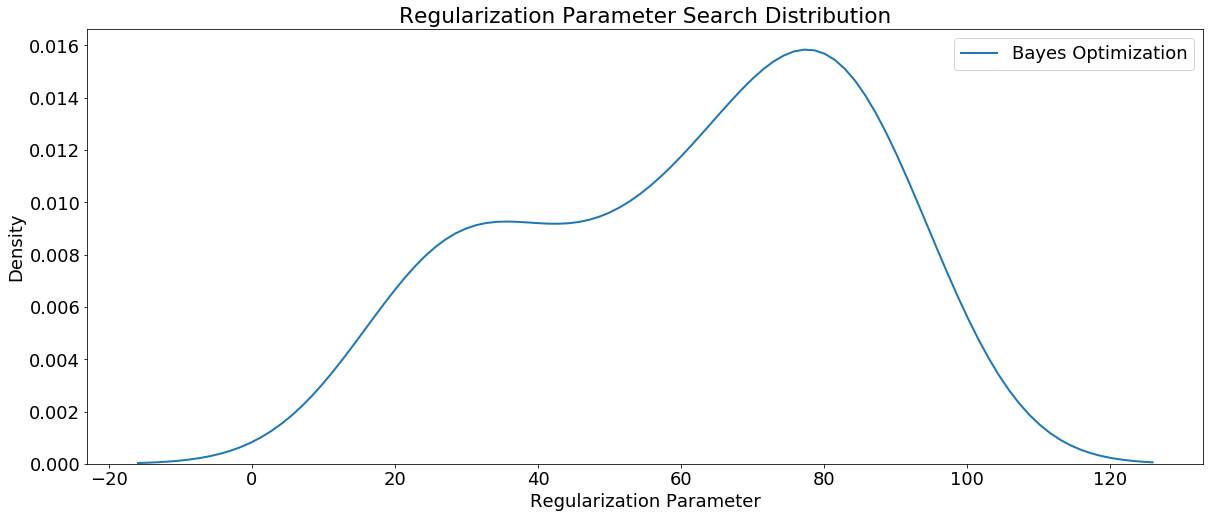

In [27]:
plt.figure(figsize=(20, 8))
plt.rcParams["font.size"] = 18

# Density plots of the learning rate distributions
sns.kdeplot(bayes_params["reg"], label="Bayes Optimization", linewidth=2)
plt.xlabel("Regularization Parameter")
plt.ylabel("Density")
plt.title("Regularization Parameter Search Distribution")

Text(0.5, 1.0, 'Regularization Parameter Search Distribution')

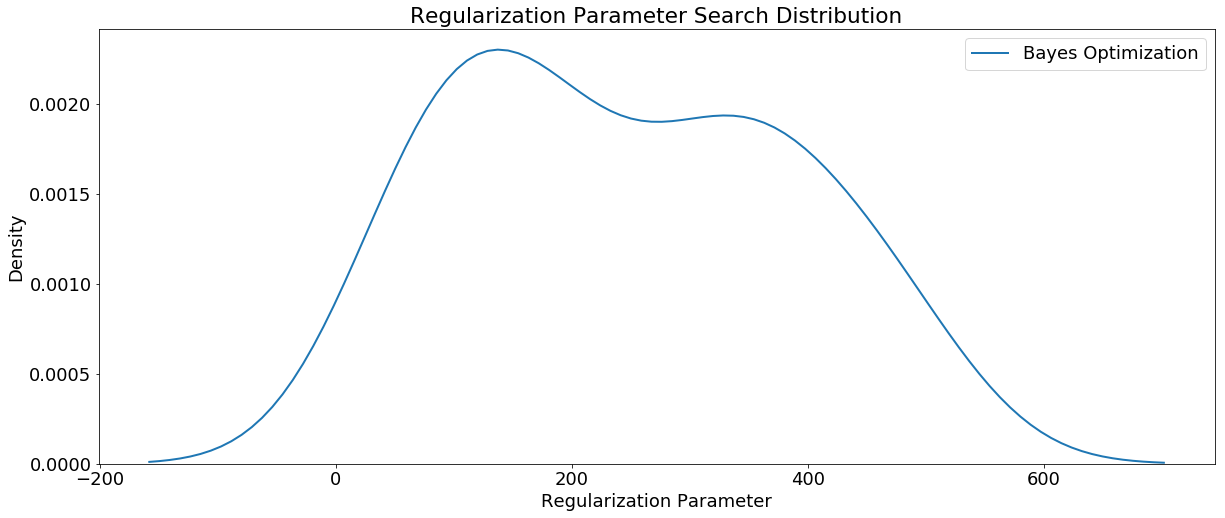

In [28]:
plt.figure(figsize=(20, 8))
plt.rcParams["font.size"] = 18

sns.kdeplot(bayes_params["iters"], label="Bayes Optimization", linewidth=2)
plt.xlabel("Regularization Parameter")
plt.ylabel("Density")
plt.title("Regularization Parameter Search Distribution")

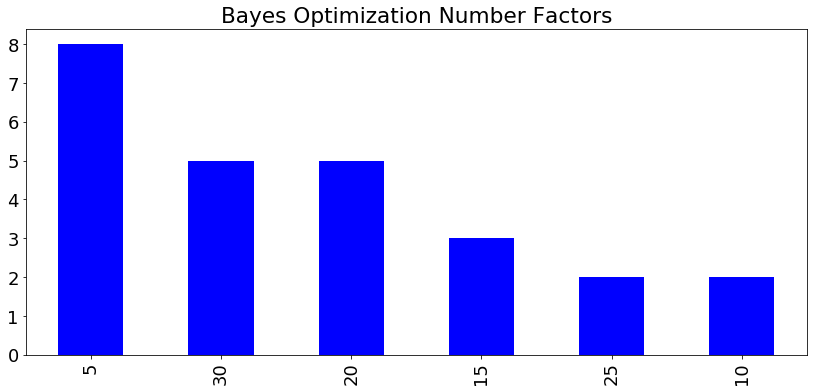

In [29]:
bayes_params["num_factors"].value_counts().plot.bar(
    figsize=(14, 6), color="blue", title="Bayes Optimization Number Factors"
)

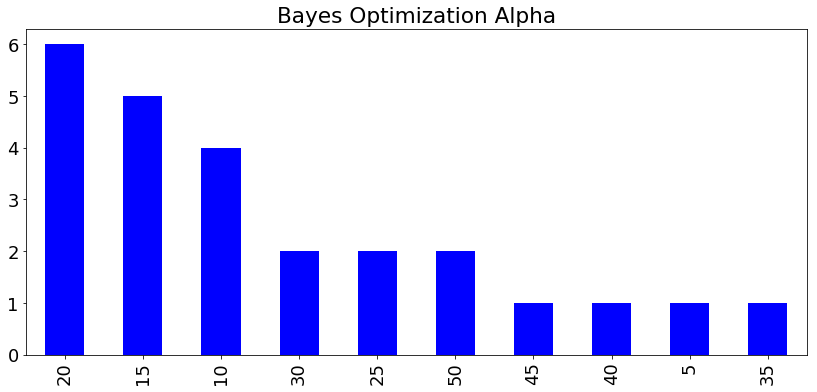

In [30]:
bayes_params["alpha"].value_counts().plot.bar(
    figsize=(14, 6), color="blue", title="Bayes Optimization Alpha"
)

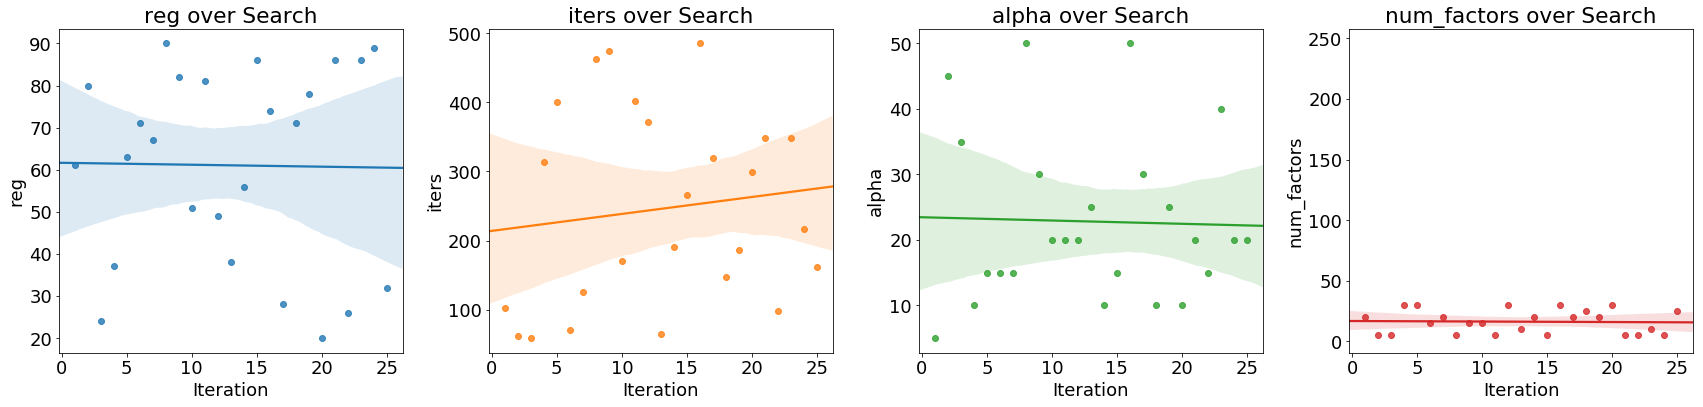

In [31]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(["reg", "iters", "alpha", "num_factors"]):
    # Scatterplot
    sns.regplot("iteration", hyper, data=bayes_params, ax=axs[i])
    axs[i].set(
        xlabel="Iteration",
        ylabel="{}".format(hyper),
        title="{} over Search".format(hyper),
    )

plt.tight_layout()

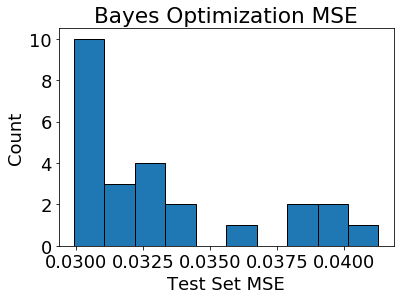

In [32]:
plt.hist(bayes_params["loss"], label="Bayes Optimization", edgecolor="k")
plt.xlabel("Test Set MSE")
plt.ylabel("Count")
plt.title("Bayes Optimization MSE")

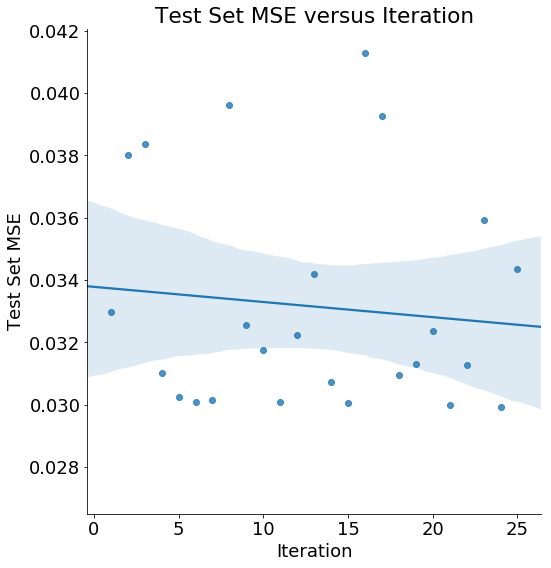

In [33]:
# Plot of scores over the course of searching
sns.lmplot("iteration", "loss", data=bayes_params, size=8)
plt.xlabel("Iteration")
plt.ylabel("Test Set MSE")
plt.title("Test Set MSE versus Iteration")

In [34]:
# Save dataframes of parameters
bayes_params.to_csv("./results/bayes_params.csv", index=False)

### Fit the ALS model with tuned parameters

Fit the ALS model and return the user and item vectors

In [35]:
best_model, user_vecs, item_vecs = als_model.fit_als(
    alpha=best_params["alpha"],
    num_factors=best_params["num_factors"],
    reg=best_params["reg"],
    iters=best_params["iters"],
)

### Get the MSE on the training and test sets

In [36]:
training_mse, test_set_mse = als_model.get_mse(
    user_vecs, item_vecs, train_df_mapped, test_df_mapped
)

training set mse = 0.029884296775636306, test set mse = 0.02995744139881301


### Convert user and item vectors to DataFrame and map to CUST_CODE and PROD_CODE

In [37]:
user_factors, item_factors = als_model.get_user_item_factors(
    user_vecs, item_vecs, train_df_mapped, train_items_mapping, train_cust_mapping
)

In [38]:
user_factors.head()

,factor_0,factor_1,factor_2,factor_3,factor_4,CUST_CODE
0,0.015998,0.004285,0.011275,0.010576,0.012515,CUST0000000013
1,0.089028,-0.106359,0.148901,0.109556,0.100083,CUST0000000055
2,0.004424,0.016657,0.019211,-0.000916,-0.000720,CUST0000000679
3,0.006272,0.006118,0.008476,0.003916,-0.004483,CUST0000001052
4,0.005155,-0.000453,0.008740,0.012690,0.010410,CUST0000001058


In [39]:
item_factors.head()

,factor_0,factor_1,factor_2,factor_3,factor_4,PROD_CODE
0,0.326456,0.230012,0.486178,0.353130,0.103477,PRD0900121
1,0.040455,0.057082,0.058655,0.145091,0.126039,PRD0900161
2,0.043378,0.100436,0.035514,0.028367,-0.012243,PRD0900234
3,0.020408,0.038742,0.001891,0.023434,0.020836,PRD0900330
4,0.197696,-0.116625,0.222180,0.081353,0.117213,PRD0900434


In [40]:
# Upload user and item factors to s3

item_factors.to_csv("./results/item_factors.csv", index=False)
key = "item_factors.csv"  # filepath in s3
s3.Bucket(bucket).Object(key).upload_file("./results/item_factors.csv")

user_factors.to_csv("./results/user_factors.csv", index=False)
key = "user_factors.csv"  # filepath in s3
s3.Bucket(bucket).Object(key).upload_file("./results/user_factors.csv")

### Create DataFrame of predicitions

In [41]:
predictions = als_model.predict(user_vecs, item_vecs, train_df_mapped, 1000)
predictions.head()

,PRED_QUANTITY,pred_rank,CUST_CODE,PROD_CODE
0,0.016720,41.0,CUST0000000013,PRD0900121
1,0.126036,40.0,CUST0000000055,PRD0900121
2,0.014217,31.0,CUST0000000679,PRD0900121
3,0.008495,22.0,CUST0000001052,PRD0900121
4,0.011386,43.0,CUST0000001058,PRD0900121


In [42]:
# Upload the predictions file to s3
predictions.to_csv("predictions.csv")
key = "predictions.csv"  # filepath in s3
s3.Bucket(bucket).Object(key).upload_file("predictions.csv")